In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv
/kaggle/input/playground-series-s3e4/sample_submission.csv
/kaggle/input/playground-series-s3e4/train.csv
/kaggle/input/playground-series-s3e4/test.csv


In [2]:
from pathlib import Path # Import OS path libraries
from sklearn.preprocessing import LabelEncoder # Encode things

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import optuna

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
input_path = Path('/kaggle/input/playground-series-s3e4')

trn_df = pd.read_csv(input_path / 'train.csv')
tst_df = pd.read_csv(input_path / 'test.csv')

original = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

submission = pd.read_csv(input_path / 'sample_submission.csv')

In [5]:
trn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219129 entries, 0 to 219128
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      219129 non-null  int64  
 1   Time    219129 non-null  float64
 2   V1      219129 non-null  float64
 3   V2      219129 non-null  float64
 4   V3      219129 non-null  float64
 5   V4      219129 non-null  float64
 6   V5      219129 non-null  float64
 7   V6      219129 non-null  float64
 8   V7      219129 non-null  float64
 9   V8      219129 non-null  float64
 10  V9      219129 non-null  float64
 11  V10     219129 non-null  float64
 12  V11     219129 non-null  float64
 13  V12     219129 non-null  float64
 14  V13     219129 non-null  float64
 15  V14     219129 non-null  float64
 16  V15     219129 non-null  float64
 17  V16     219129 non-null  float64
 18  V17     219129 non-null  float64
 19  V18     219129 non-null  float64
 20  V19     219129 non-null  float64
 21  V20     21

In [6]:
trn_df.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,...,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,...,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,...,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,...,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,...,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0


In [7]:
original.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
trn_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,219129.0,109564.000000,63257.237906,0.000000,54782.000000,109564.000000,164346.000000,219128.000000
Time,219129.0,62377.415376,25620.348569,0.000000,47933.000000,63189.000000,77519.000000,120580.000000
V1,219129.0,0.096008,1.395425,-29.807725,-0.846135,0.385913,1.190661,2.430494
V2,219129.0,0.048345,1.159805,-44.247914,-0.573728,0.046937,0.814145,16.068473
V3,219129.0,0.592102,1.132884,-19.722872,-0.027154,0.735895,1.306110,6.145578
V4,219129.0,0.069273,1.253125,-5.263650,-0.769256,0.064856,0.919353,12.547997
V5,219129.0,-0.161555,1.069530,-37.591259,-0.847346,-0.229929,0.356856,34.581260
V6,219129.0,0.133688,1.202411,-25.659750,-0.631835,-0.087778,0.482388,16.233967
V7,219129.0,-0.128224,0.817207,-31.179799,-0.646730,-0.098970,0.385567,39.824099
V8,219129.0,0.149534,0.716212,-28.903442,-0.095948,0.111219,0.390976,18.270586


In [9]:
trn_df.isnull().sum()

id        0
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [10]:
def across_col_feat(df):
    '''
    Calculates features across colums...
    '''
    features = [feat for feat in df.columns if 'V' in feat]
    df['V_Sum'] = df[features].sum(axis = 1)
    df['V_Min'] = df[features].min(axis = 1)
    df['V_Max'] = df[features].max(axis = 1)
    df['V_Avg'] = df[features].mean(axis = 1)
    df['V_Std'] = df[features].std(axis = 1)
    df['V_Pos'] = df[features].gt(0).sum(axis = 1)
    df['V_Neg'] = df[features].lt(0).sum(axis = 1)
    df['V_Var'] = df[features].var(axis = 1)
    # df['V_Mad'] = df[features].mad(axis = 1)
    # df['V_Range'] = abs(df['V_Min'] - df['V_Max'])

    return df

trn_df = across_col_feat(trn_df)
tst_df = across_col_feat(tst_df) 

In [11]:
def integer_part(df):
    '''
    Extract the integer and decimal part of the transaction...
    '''
    df['Decimal'] = df['Amount'] % 1
    df['Integer'] = df['Amount'] - df['Decimal']
    
    return df

#trn_df = integer_part(trn_df)
#tst_df = integer_part(tst_df)

In [12]:
def small_amounts(df):
    '''
    Identify transactions with 0 or 1 amount
    '''
    df['is_cero'] = df['Amount'] == 0
    df['is_one'] = df['Amount'] == 1
    
    return df

#trn_df = small_amounts(trn_df)
#tst_df = small_amounts(tst_df)

In [13]:
def create_time_features(df):
    '''
    Create features using the time variable
    '''
    
    df['Time'] = pd.cut(df['Time'] % (3600 * 24),
                              bins=[0, 6, 12, 18, 24],
                              labels=["early_morning", "morning", "afternoon", "night"]
                             )
    return df

#trn_df = create_time_features(trn_df)
#tst_df = create_time_features(tst_df)

In [14]:
trn_df.head(15)

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,Amount,Class,V_Sum,V_Min,V_Max,V_Avg,V_Std,V_Pos,V_Neg,V_Var
0,0,0.00,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,...,1.98,0,-3.188276,-1.210144,2.074329,-0.113867,0.658850,11,17,0.434083
1,1,0.00,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,...,84.00,0,-1.687735,-1.250891,1.998827,-0.060276,0.749114,9,19,0.561172
2,2,0.00,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,...,2.69,0,-2.194632,-0.988351,1.004517,-0.078380,0.547719,11,17,0.299996
3,3,0.00,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,...,1.00,0,-0.629635,-1.504823,1.979649,-0.022487,0.650917,9,19,0.423693
4,4,0.00,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,...,1.00,0,5.611024,-0.938651,1.391399,0.200394,0.652517,16,12,0.425778
5,5,0.00,1.052469,0.099592,1.077244,1.370024,-0.471625,0.238658,-0.281837,0.055925,...,35.97,0,4.236782,-0.927470,1.719085,0.151314,0.647871,17,11,0.419736
6,6,0.00,1.206129,0.420150,-0.358910,1.037382,0.735224,-0.082449,0.568558,-0.158037,...,36.00,0,1.120982,-1.113867,1.206129,0.040035,0.625058,13,15,0.390697
7,7,0.00,-1.074970,-0.297535,-0.884465,0.065341,-0.239956,0.349602,1.756880,0.054202,...,440.00,0,3.295761,-1.074970,1.756880,0.117706,0.680083,17,11,0.462513
8,8,0.00,2.154065,-0.000479,-2.125939,-0.121096,0.918473,-0.208507,0.226055,-0.236828,...,1.00,0,4.127331,-2.125939,2.154065,0.147405,0.724967,15,13,0.525577
9,9,0.00,2.172667,-0.704020,-1.447412,-0.715805,-0.530117,-1.007526,-0.436662,-0.176599,...,10.00,0,-1.840777,-1.957759,2.172667,-0.065742,0.885403,12,16,0.783939


In [15]:
def flag_duplicates(df, remove = True):
    '''
    Flag the dataframe to indicate if there are duplicates
    '''
    v_features = [x for x in df.columns if x not in ['id', 'Time']]
    df['Duplicate'] = 0
    df.loc[df[v_features].duplicated(keep = False), 'Duplicate'] = 1
    
    if remove:
        df = df[df['Duplicate'] == 0]
        
    return df

#trn_df = flag_duplicates(trn_df) 
#tst_df = flag_duplicates(tst_df, remove = False) 

In [16]:
trn_df.head().T

,0,1,2,3,4
id,0.000000,1.000000,2.000000,3.000000,4.000000
Time,0.000000,0.000000,0.000000,0.000000,0.000000
V1,2.074329,1.998827,0.091535,1.979649,1.025898
V2,-0.129425,-1.250891,1.004517,-0.184949,-0.171827
V3,-1.137418,-0.520969,-0.223445,-1.064206,1.203717
V4,0.412846,-0.894539,-0.435249,0.120125,1.243900
V5,-0.192638,-1.122528,0.667548,-0.215238,-0.636572
V6,-1.210144,-0.270866,-0.988351,-0.648829,1.099074
V7,0.110697,-1.029289,0.948146,-0.087826,-0.938651
V8,-0.263477,0.050198,-0.084789,-0.035367,0.569239


In [17]:
def create_onehot(trn_df, tst_df, list_of_var = ['Time']):
    '''
    Onehot encoding multiple features.... 
    '''
    trn_df['Is_train'] = 1
    tst_df['Is_train'] = 0
    df = pd.concat([trn_df, tst_df])
    df = pd.get_dummies(df, columns = list_of_var)
    
    trn_df = df[df['Is_train'] == 1]
    tst_df = df[df['Is_train'] == 0]
    
    trn_df = trn_df.drop(['Is_train'], axis = 1)
    tst_df = tst_df.drop(['Is_train'], axis = 1)
    
    return trn_df,tst_df

# Will not be used in this iteration...
# trn_df, tst_df = create_onehot(trn_df, tst_df, list_of_var = ['Time'])

In [18]:
def feature_encoder(trn, tst, list_of_var = ['Time']):
    '''
    Encode multiple features...
    '''
    
    encoded_feat = []
    trn['Is_train'] = 1
    tst['Is_train'] = 0
        
    df = pd.concat([trn,tst])

    for var in list_of_var:
        encoder = LabelEncoder()
        df[var + '_enc'] = encoder.fit_transform(df[var])
        encoded_feat.append(var + '_enc')
    
    trn = df[df['Is_train'] == 1]
    tst = df[df['Is_train'] == 0]
    
    trn = trn.drop(list_of_var, axis=1)
    tst = tst.drop(list_of_var, axis=1)
    return trn, tst, encoded_feat

#trn_df, tst_df, enc_feat = feature_encoder(trn_df, tst_df, list_of_var = ['Time'])

In [19]:
TARGET = 'Class'
features = [feat for feat in trn_df.columns if feat not in ['id', 'Generated', 'Duplicate', TARGET]]

In [20]:
trn_df['Train'] = 1
tst_df['Train'] = 0

merge_data = pd.concat([trn_df,tst_df])

In [21]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
v_features = ['V'+str(i) for i in range(1,29)]
kmean_features = v_features
#scaler = StandardScaler()
#scaler.fit(trn_df[kmean_features])
#X = scaler.transform(trn_df[kmean_features])

kmeans = KMeans(n_clusters = 5).fit(merge_data[kmean_features])

In [22]:
merge_data[kmean_features].describe().T

,count,mean,std,min,25%,50%,75%,max
V1,365216.0,0.262777,1.506912,-34.755944,-0.793351,0.337029,1.397576,2.452901
V2,365216.0,0.023768,1.196136,-44.247914,-0.633161,0.037208,0.819057,16.068473
V3,365216.0,0.076268,1.355516,-19.722872,-0.818084,0.205973,1.062766,6.145578
V4,365216.0,-0.067740,1.310137,-5.497560,-0.884745,-0.120856,0.724245,12.547997
V5,365216.0,0.031810,1.126029,-37.591259,-0.717274,-0.039690,0.650901,34.581260
V6,365216.0,0.060131,1.259450,-25.659750,-0.739660,-0.195158,0.418383,16.596635
V7,365216.0,-0.047567,0.876889,-31.179799,-0.627189,-0.036081,0.539303,39.824099
V8,365216.0,0.107241,0.731550,-28.903442,-0.148042,0.078115,0.363320,18.270586
V9,365216.0,-0.057650,1.004542,-8.756951,-0.680082,-0.098909,0.557927,13.423914
V10,365216.0,-0.018270,0.868204,-22.092656,-0.547482,-0.093359,0.459816,15.878405


In [23]:
kmean_centroids = kmeans.cluster_centers_
#kmean_centroids = scaler.inverse_transform(kmean_centroids)

In [24]:
def centers_to_dataframe(features, kmean_centers):
    '''
    
    '''
    colNames = list(features)
    colNames.append('Prediction')

    # Zip with a column called 'MedHouseVal' (index)
    Z = [np.append(A, index) for index, A in enumerate(kmean_centers)]

    # Convert to pandas data frame for plotting
    P = pd.DataFrame(Z, columns=colNames)
    P['Prediction'] = P['Prediction'].astype(int)
    return P

centroids_df = centers_to_dataframe(kmean_features, kmean_centroids)

In [25]:
merge_data['Cluster_Number'] = centroids_df['Prediction']
trn_df = merge_data[merge_data['Train'] == 1]
tst_df = merge_data[merge_data['Train'] == 0]

In [26]:
def scale_features(train, test, features):
    '''
    Scale the features, this helps to improve some of the ml algorithm performance
    '''
    scalar = RobustScaler()
    train[features] = scalar.fit_transform(train[features])
    test[features] = scalar.transform(test[features])
    return train, test

trn_df, tst_df = scale_features(trn_df, tst_df, features)

In [27]:
TARGET = 'Class'
ignore = ['id', 'Generated', 'Duplicate', 'Train', TARGET, 'Cluster_Number', 'V_Var', 
         # 'Time'
         ]
features = [feat for feat in trn_df.columns if feat not in ignore]

In [28]:
trn_df.columns

Index(['id', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'V_Sum', 'V_Min', 'V_Max', 'V_Avg', 'V_Std', 'V_Pos', 'V_Neg',
       'V_Var', 'Train', 'Cluster_Number'],
      dtype='object')

In [29]:
features

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'V_Sum',
 'V_Min',
 'V_Max',
 'V_Avg',
 'V_Std',
 'V_Pos',
 'V_Neg']

In [30]:
def catboost_objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0, 0.3)
    depth = trial.suggest_int('depth', 3, 12)
    n_estimators = trial.suggest_int('n_estimators', 50, 4096)
    
    model = XGBClassifier(
        n_estimators      = n_estimators,
        max_depth         = depth,
        learning_rate     = learning_rate,
        min_child_weight  = 96, 
        colsample_bytree  = 0.95, 
        subsample         = 0.95, 
        reg_lambda        = 1.50,
        reg_alpha         = 1.50,
        gamma             = 1.50,
        random_state      = 5,
        objective         = 'binary:logistic',
        tree_method       = 'hist',
        eval_metric       = 'auc',)
    
    kf = KFold(n_splits = 5)
    cv_score = cross_val_score(model, trn_df[features], trn_df[TARGET], scoring = 'roc_auc', cv = kf)
    return np.mean(cv_score)

In [31]:
xgb_params = {'n_estimators'     : 3093,
              'min_child_weight' : 96,
              'max_depth'        : 12,
              'learning_rate'    : 0.07516,
              'subsample'        : 0.95,
              'colsample_bytree' : 0.95,
              'reg_lambda'       : 1.50,
              'reg_alpha'        : 1.50,
              'gamma'            : 1.50,
              'max_bin'          : 512,
              'objective'        : 'binary:logistic',
              'tree_method'      : 'hist',
              'eval_metric'      : 'auc'
             }

In [32]:
score_list   = []
predictions  = [] 
xgb_models   = []

# Define kfolds for training purposes...
kf = StratifiedKFold(n_splits = 10, random_state = 5, shuffle = True)

# Initialize the training loop...
for fold, (trn_idx, val_idx) in enumerate(kf.split(trn_df[features], trn_df[TARGET])):
    print(f'Training Fold {fold} ...')
    X_train, X_valid = trn_df.iloc[trn_idx][features], trn_df.iloc[val_idx][features]
    y_train, y_valid = trn_df.iloc[trn_idx][TARGET], trn_df.iloc[val_idx][TARGET]
    
    # Create and Train an XGBoost
    xgb_model = XGBClassifier(**xgb_params)
    xgb_model.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], early_stopping_rounds = 512, verbose = 0)
    
    y_valid_pred = xgb_model.predict_proba(X_valid.values)[:,1]
    score = roc_auc_score(y_valid, y_valid_pred)
    
    score_list.append(score)
    print(f"Fold {fold}, AUC = {score:.4f}")
    print((''))
    
    xgb_models.append(xgb_model)
    tst_pred = xgb_model.predict_proba(tst_df[features].values)[:,1]
    predictions.append(tst_pred)

print(f'OOF AUC: {np.mean(score_list):.4f}')
print('.........')

Training Fold 0 ...
Fold 0, AUC = 0.8101

Training Fold 1 ...
Fold 1, AUC = 0.8094

Training Fold 2 ...
Fold 2, AUC = 0.8192

Training Fold 3 ...
Fold 3, AUC = 0.7944

Training Fold 4 ...
Fold 4, AUC = 0.8497

Training Fold 5 ...
Fold 5, AUC = 0.7863

Training Fold 6 ...
Fold 6, AUC = 0.8319

Training Fold 7 ...
Fold 7, AUC = 0.8440

Training Fold 8 ...
Fold 8, AUC = 0.8526

Training Fold 9 ...
Fold 9, AUC = 0.8262

OOF AUC: 0.8224
.........


In [33]:
def plot_feature_importance(importance, names, model_type, max_features = 10):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df.head(max_features)

    #Define size of bar plot
    plt.figure(figsize=(15,10))
    
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

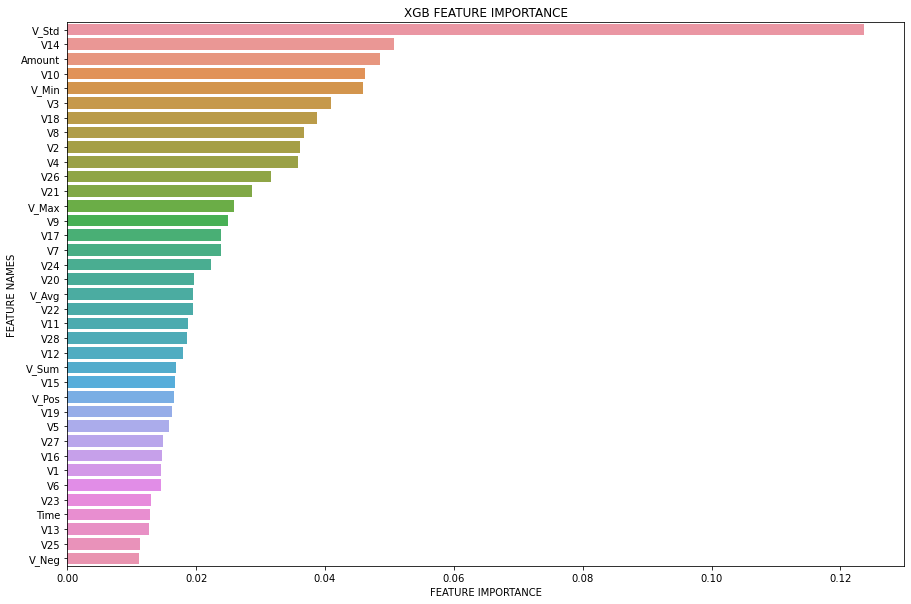

In [34]:
plot_feature_importance(xgb_model.feature_importances_,X_train.columns,'XGB ', max_features = 70)

In [35]:
xgboost_preds = np.array(predictions).mean(axis=0)
submission['Class'] = xgboost_preds
submission.to_csv('xgb_submission.csv', index = False)

In [36]:
submission.head()

,id,Class
0,219129,0.001543
1,219130,0.001279
2,219131,0.000929
3,219132,0.002479
4,219133,0.000979


In [37]:

lgb_params = {'num_iterations'   : 772,
              'max_depth'        : 3,
              'learning_rate'    : 0.0293466,
              'min_child_samples': 36, 
              'num_leaves'       : 128, 
              'colsample_bytree' : 0.80, 
              'subsample'        : 0.90, 
              'subsample_freq'   : 5, 
              'reg_lambda'       : 28,
              '5'             : 5,
              'objective'        : 'binary',
              'boosting_type'    : 'gbdt',
              'device'           : 'cpu', 
              'gpu_platform_id'  : 0,
              'gpu_device_id'    : 0,
              'n_jobs'           : -1,
              'metric'           : 'auc',
              'verbose'          : -1,
             }

In [38]:

score_list   = []
predictions  = [] 
lgb_models   = []

# Define kfolds for training purposes...
# kf = KFold(n_splits = 10, shuffle = True, random_state=5)
kf = StratifiedKFold(n_splits = 10, random_state = 5, shuffle = True)
# Initialize the training loop...
for fold, (trn_idx, val_idx) in enumerate(kf.split(trn_df[features], trn_df[TARGET])):
    print(f'Training Fold {fold} ...')
    X_train, X_valid = trn_df.iloc[trn_idx][features], trn_df.iloc[val_idx][features]
    y_train, y_valid = trn_df.iloc[trn_idx][TARGET], trn_df.iloc[val_idx][TARGET]
    
    # Create and Train an LGBM Model
    lgb_model = LGBMClassifier(**lgb_params)
    lgb_model.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], early_stopping_rounds = 512, verbose = 0)
    
    y_valid_pred = lgb_model.predict_proba(X_valid.values)[:,1]
    score = roc_auc_score(y_valid, y_valid_pred)
    
    score_list.append(score)
    print(f"Fold {fold}, AUC = {score:.4f}")
    print((''))
    
    lgb_models.append(lgb_model)
    tst_pred = lgb_model.predict_proba(tst_df[features].values)[:,1]
    predictions.append(tst_pred)

print(f'OOF AUC: {np.mean(score_list):.4f}')
print('.........')

Training Fold 0 ...
[LightGBM] [Warning] Unknown parameter: 5
Fold 0, AUC = 0.8142

Training Fold 1 ...
[LightGBM] [Warning] Unknown parameter: 5
Fold 1, AUC = 0.7907

Training Fold 2 ...
[LightGBM] [Warning] Unknown parameter: 5
Fold 2, AUC = 0.8091

Training Fold 3 ...
[LightGBM] [Warning] Unknown parameter: 5
Fold 3, AUC = 0.7946

Training Fold 4 ...
[LightGBM] [Warning] Unknown parameter: 5
Fold 4, AUC = 0.8600

Training Fold 5 ...
[LightGBM] [Warning] Unknown parameter: 5
Fold 5, AUC = 0.7864

Training Fold 6 ...
[LightGBM] [Warning] Unknown parameter: 5
Fold 6, AUC = 0.8408

Training Fold 7 ...
[LightGBM] [Warning] Unknown parameter: 5
Fold 7, AUC = 0.8502

Training Fold 8 ...
[LightGBM] [Warning] Unknown parameter: 5
Fold 8, AUC = 0.8498

Training Fold 9 ...
[LightGBM] [Warning] Unknown parameter: 5
Fold 9, AUC = 0.8356

OOF AUC: 0.8231
.........


In [39]:
lgbm_preds = np.array(predictions).mean(axis=0)
submission['Class'] = lgbm_preds
submission.to_csv('lgbm_submission.csv', index = False)

In [40]:
submission.head()

,id,Class
0,219129,0.001309
1,219130,0.001074
2,219131,0.000761
3,219132,0.002349
4,219133,0.000791


In [41]:
cb_params = {'num_boost_round': 1420,
             'depth': 3,
             'learning_rate': 0.04895188,
             'rsm': 0.5,
             'subsample': 0.931,
             'l2_leaf_reg': 69,
             'min_data_in_leaf': 20,
             'random_strength': 0.175,
             'random_seed': 5,
             'use_best_model': True,
             'task_type': 'CPU',
             'bootstrap_type': 'Bernoulli',
             'grow_policy': 'SymmetricTree',
             'loss_function': 'Logloss',
             'eval_metric': 'AUC'
            }

In [42]:
score_list   = []
predictions  = [] 
cat_models   = []

# Define kfolds for training purposes...
# kf = KFold(n_splits = 10, shuffle = True, random_state = 5)
kf = StratifiedKFold(n_splits = 10, random_state = 5, shuffle = True)
# Initialize the training loop...
for fold, (trn_idx, val_idx) in enumerate(kf.split(trn_df[features], trn_df[TARGET])):
    print(f'Training Fold {fold} ...')
    X_train, X_valid = trn_df.iloc[trn_idx][features], trn_df.iloc[val_idx][features]
    y_train, y_valid = trn_df.iloc[trn_idx][TARGET], trn_df.iloc[val_idx][TARGET]
    
    # Create and Train an LGBM Model
    cat_model = CatBoostClassifier(**cb_params)
    cat_model.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], early_stopping_rounds = 512, verbose = 0)
    
    y_valid_pred = cat_model.predict_proba(X_valid.values)[:,1]
    score = roc_auc_score(y_valid, y_valid_pred)
    
    score_list.append(score)
    print(f"Fold {fold}, AUC = {score:.4f}")
    print((''))
    
    cat_models.append(cat_model)
    tst_pred = cat_model.predict_proba(tst_df[features].values)[:,1]
    predictions.append(tst_pred)

print(f'OOF AUC: {np.mean(score_list):.4f}')
print('.........')

Training Fold 0 ...
Fold 0, AUC = 0.8040

Training Fold 1 ...
Fold 1, AUC = 0.7959

Training Fold 2 ...
Fold 2, AUC = 0.8311

Training Fold 3 ...
Fold 3, AUC = 0.7778

Training Fold 4 ...
Fold 4, AUC = 0.8594

Training Fold 5 ...
Fold 5, AUC = 0.7965

Training Fold 6 ...
Fold 6, AUC = 0.8170

Training Fold 7 ...
Fold 7, AUC = 0.8656

Training Fold 8 ...
Fold 8, AUC = 0.8330

Training Fold 9 ...
Fold 9, AUC = 0.8308

OOF AUC: 0.8211
.........


In [45]:
submission.to_csv('submission.csv', index = False)

In [46]:
submission.head()

,id,Class,Attrition
0,219129,0.001309,0.001556
1,219130,0.001074,0.001197
2,219131,0.000761,0.000767
3,219132,0.002349,0.003700
4,219133,0.000791,0.001854
